# Feature Creation notebook - version E
## Big refactor from version D brought on by doing some of the loading and combining in the wellKNN notebook
_Goal is to start with dict of dataframes of wells and a few other pieces and create a single dataframe with all the necessary features for all used wells_

##### by Justin Gosses 2018-10-03

#### Inputs used during this notebook are:
redo this cell!!!

In [14]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import welly
from welly import Well
import lasio
import glob
from sklearn import neighbors
import pickle
import math
import dask
import dask.dataframe as dd
from dask.distributed import Client
# import pdvega
# import vega
import dask.dataframe as dd
from dask.distributed import Client
welly.__version__

'0.3.5'

In [15]:
print(dask.__version__)
print(pd.__version__)

0.18.2
0.23.3


In [16]:
%%timeit
import os
env = %env


81.6 µs ± 1.82 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
from IPython.display import display

In [18]:
#### Test results Part 1
#### Had to change display options to get this to print in full!
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100000

## Path to directories

In [19]:
knn_dir = "../WellsKNN/"
load_dir = "../loadLAS/"
wells_knn_dir = "../WellsKNN/"

## H5 file imported with a dataframe of the wells that have been loaded, limited to the ones with the right tops and curves and knn neighbor thinkness feature columns added

In [20]:
wells_load_clean_knn_df = 'wells_curves_picks_knn_nofeatures_20190928_a.h5'

## H5 file imported with wells' curve data but only the wells that have the tops and curves we specified in checks and load notebooks

In [25]:
df_curves_inCheckedWells_nameh5 = 'wellsLoaded_checked_curveDataOnly.h5'


-------------

## We're going to load a h5 file of a previously created dataframe of the pick depths

In [26]:
df_all_wells_wKNN = pd.read_hdf(wells_knn_dir+wells_load_clean_knn_df, 'df')

In [27]:
df_all_wells_wKNN.head()

,SitID,lat,lng,UWI,TopHelper_HorID,TopTarget_HorID,TopHelper_DEPTH,TopTarget_DEPTH,TopHelper_HorID_Qual,TopTarget_Qual,Neighbors_Obj,NN1_topTarget_DEPTH,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,MM_Top_Depth_Real_v_predBy_NN1thick
0,102496,54.785907,-110.129320,00/12-08-067-01W4/0,14000,13000,561.0,475.0,1,3,"[{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.05753100195547899}, {'neighbor': 2, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.08749430324884858}, {'neighbor': 3, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.10451669032744222}, {'neighbor': 4, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.1099989647224123}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.14017282905400244}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.14539497462086076}, {'neighbor': 7, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.14676425482044453}]",544.0,630.0,86.0,475.0,0.0
1,102497,54.782284,-110.269446,00/07-08-067-02W4/0,14000,13000,604.5,515.0,1,3,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.04734000608365529}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.07332213830078355}, {'neighbor': 3, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.07846755926496476}, {'neighbor': 4, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.08267376663125782}, {'neighbor': 5, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.09089701215112062}, {'neighbor': 6, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.11681159403073145}, {'neighbor': 7, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.1228254786597645}]",529.0,613.0,84.0,520.5,-5.5
2,102498,54.785892,-110.186851,00/09-11-067-02W4/0,14000,13000,564.0,480.0,1,3,"[{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0', 'distance': 0.05753100195547899}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.06649378619088428}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.08267376663125782}, {'neighbor': 4, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.08728400165551212}, {'neighbor': 5, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.09343691917544036}, {'neighbor': 6, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.10808166919974113}, {'neighbor': 7, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.12013967631468725}]",529.0,613.0,84.0,480.0,0.0
3,102500,54.829624,-110.269422,00/10-29-067-02W4/0,14000,13000,636.5,549.0,1,3,"[{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.04355700607250212}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.04589036401030715}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.04734000608365529}, {'neighbor': 4, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.07898840474399109}, {'neighbor': 5, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.08169505420160347}, {'neighbor': 6, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.09336784482892224}, {'neighbor': 7, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.09343691917544036}]",529.0,613.0,84.0,552.5,-3.5
4,102501,54.840471,-110.224832,00/06-34-067-02W4/0,14000,13000,613.0,529.0,1,2,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.04589036401030715}, {'neighbor': 2, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.050134469469623355}, {'neighbor': 3, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.055282561346227096}, {'neighbor': 4, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.06649378619088428}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.07332213830078355}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.07715524006184091}, {'neighbor': 7, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.10684705044597653}]",514.0,603.0,89.0,524.0,5.0


### One column has wrong name, so we'll rename it, we should go back and change it in the function later!

In [40]:
df_all_wells_wKNN.rename(columns={'MM_Top_Depth_Real_v_predBy_NN1thick':'diff_Top_Depth_Real_v_predBy_NN1thick'}, inplace=True)

## We're also going to load an h5 file of the wells curve datasets

In [28]:
df_curves_inCheckedWells = pd.read_hdf(wells_knn_dir+df_curves_inCheckedWells_nameh5, 'df')

In [29]:
df_curves_inCheckedWells.head()

,CALI,COND,DELT,DEPT,DPHI,DT,GR,ILD,ILM,NPHI,PHID,RHOB,SFL,SFLU,SN,SP,UWI,trainOrTest
0,167.003,NaN,NaN,149.602,0.227,NaN,102.473,0.000,NaN,0.460,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,train
1,199.159,NaN,NaN,149.852,0.263,NaN,122.589,4.202,NaN,0.550,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,train
2,200.496,NaN,NaN,150.102,0.252,NaN,120.196,4.643,NaN,0.537,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,train
3,203.933,NaN,NaN,150.352,0.244,NaN,115.975,5.280,NaN,0.513,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,train
4,203.664,NaN,NaN,150.602,0.240,NaN,109.271,6.592,NaN,0.487,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,train


In [ ]:
## We'll then merge those two dataframe into one based on UWI col

In [54]:
df_all_wells_wKNN = pd.merge(df_curves_inCheckedWells, df_all_wells_wKNN, on='UWI')

In [55]:
df_all_wells_wKNN[500:520]

,CALI,COND,DELT,DEPT,DPHI,DT,GR,ILD,ILM,NPHI,PHID,RHOB,SFL,SFLU,SN,SP,UWI,trainOrTest,SitID,lat,lng,TopHelper_HorID,TopTarget_HorID,TopHelper_DEPTH,TopTarget_DEPTH,TopHelper_HorID_Qual,TopTarget_Qual,Neighbors_Obj,NN1_topTarget_DEPTH,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,diff_Top_Depth_Real_v_predBy_NN1thick
500,155.121,NaN,NaN,274.602,0.250,NaN,69.812,12.396,NaN,0.468,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,train,112385,55.978836,-113.095365,14000,13000,384.66,377.95,1,3,"[{'neighbor': 1, 'UWI': '00/10-18-080-20W4/0', 'distance': 0.0507719894528512}, {'neighbor': 2, 'UWI': '00/10-18-081-20W4/0', 'distance': 0.05092214506480033}, {'neighbor': 3, 'UWI': '00/07-32-081-20W4/0', 'distance': 0.08365500059769317}, {'neighbor': 4, 'UWI': 'AA/11-14-081-20W4/0', 'distance': 0.08411400899372744}, {'neighbor': 5, 'UWI': '00/07-36-079-21W4/0', 'distance': 0.10481234193072116}, {'neighbor': 6, 'UWI': '00/13-10-081-21W4/0', 'distance': 0.12170796207727541}, {'neighbor': 7, 'UWI': '00/07-11-082-20W4/0', 'distance': 0.13725963708606176}]",389.0,414.0,25.0,359.66,18.29
501,157.257,NaN,NaN,274.852,0.295,NaN,71.018,12.270,NaN,0.499,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,train,112385,55.978836,-113.095365,14000,13000,384.66,377.95,1,3,"[{'neighbor': 1, 'UWI': '00/10-18-080-20W4/0', 'distance': 0.0507719894528512}, {'neighbor': 2, 'UWI': '00/10-18-081-20W4/0', 'distance': 0.05092214506480033}, {'neighbor': 3, 'UWI': '00/07-32-081-20W4/0', 'distance': 0.08365500059769317}, {'neighbor': 4, 'UWI': 'AA/11-14-081-20W4/0', 'distance': 0.08411400899372744}, {'neighbor': 5, 'UWI': '00/07-36-079-21W4/0', 'distance': 0.10481234193072116}, {'neighbor': 6, 'UWI': '00/13-10-081-21W4/0', 'distance': 0.12170796207727541}, {'neighbor': 7, 'UWI': '00/07-11-082-20W4/0', 'distance': 0.13725963708606176}]",389.0,414.0,25.0,359.66,18.29
502,158.792,NaN,NaN,275.102,0.323,NaN,71.268,12.075,NaN,0.501,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,train,112385,55.978836,-113.095365,14000,13000,384.66,377.95,1,3,"[{'neighbor': 1, 'UWI': '00/10-18-080-20W4/0', 'distance': 0.0507719894528512}, {'neighbor': 2, 'UWI': '00/10-18-081-20W4/0', 'distance': 0.05092214506480033}, {'neighbor': 3, 'UWI': '00/07-32-081-20W4/0', 'distance': 0.08365500059769317}, {'neighbor': 4, 'UWI': 'AA/11-14-081-20W4/0', 'distance': 0.08411400899372744}, {'neighbor': 5, 'UWI': '00/07-36-079-21W4/0', 'distance': 0.10481234193072116}, {'neighbor': 6, 'UWI': '00/13-10-081-21W4/0', 'distance': 0.12170796207727541}, {'neighbor': 7, 'UWI': '00/07-11-082-20W4/0', 'distance': 0.13725963708606176}]",389.0,414.0,25.0,359.66,18.29
503,158.737,NaN,NaN,275.352,0.318,NaN,72.706,12.057,NaN,0.488,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,train,112385,55.978836,-113.095365,14000,13000,384.66,377.95,1,3,"[{'neighbor': 1, 'UWI': '00/10-18-080-20W4/0', 'distance': 0.0507719894528512}, {'neighbor': 2, 'UWI': '00/10-18-081-20W4/0', 'distance': 0.05092214506480033}, {'neighbor': 3, 'UWI': '00/07-32-081-20W4/0', 'distance': 0.08365500059769317}, {'neighbor': 4, 'UWI': 'AA/11-14-081-20W4/0', 'distance': 0.08411400899372744}, {'neighbor': 5, 'UWI': '00/07-36-079-21W4/0', 'distance': 0.10481234193072116}, {'neighbor': 6, 'UWI': '00/13-10-081-21W4/0', 'distance': 0.12170796207727541}, {'neighbor': 7, 'UWI': '00/07-11-082-20W4/0', 'distance': 0.13725963708606176}]",389.0,414.0,25.0,359.66,18.29
504,157.886,NaN,NaN,275.602,0.316,NaN,72.439,12.307,NaN,0.484,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,train,112385,55.978836,-113.095365,14000,13000,384.66,377.95,1,3,"[{'neighbor': 1, 'UWI': '00/10-18-080-20W4/0', 'distance': 0.0507719894528512}, {'neighbor': 2, 'UWI': '00/10-18-081-20W4/0', 'distance': 0.05092214506480033}, {'neighbor': 3, 'UWI': '00/07-32-081-20W4/0', 'distance': 0.08365500059769317}, {'neighbor': 4, 'UWI': 'AA/11-14-081-20W4/0', 'distance': 0.08411400899372744}, {'neighbor': 5, 'UWI': '00/07-36-079-21W4/0', 'distance': 0.10481234193072116}, {'neighbor': 6, 'UWI': '00/13-10-081-2

In [56]:
#### Check number of wells
len(df_all_wells_wKNN.UWI.unique())

1601

--------------------

## After joining on the nearest neighbor dataframe, we can cast the original columns to floats instead of strings which some but not necessarily all might be. 
When we do this, be careful about variation in depth column name and rename DEPTH and DEPT to DEPTH

In [57]:
columns = list(df_all_wells_wKNN.columns.values)

In [58]:
columns

['CALI',
 'COND',
 'DELT',
 'DEPT',
 'DPHI',
 'DT',
 'GR',
 'ILD',
 'ILM',
 'NPHI',
 'PHID',
 'RHOB',
 'SFL',
 'SFLU',
 'SN',
 'SP',
 'UWI',
 'trainOrTest',
 'SitID',
 'lat',
 'lng',
 'TopHelper_HorID',
 'TopTarget_HorID',
 'TopHelper_DEPTH',
 'TopTarget_DEPTH',
 'TopHelper_HorID_Qual',
 'TopTarget_Qual',
 'Neighbors_Obj',
 'NN1_topTarget_DEPTH',
 'NN1_TopHelper_DEPTH',
 'NN1_thickness',
 'topTarget_Depth_predBy_NN1thick',
 'diff_Top_Depth_Real_v_predBy_NN1thick']

We'll turn everything except UWI, SiteID, and Neighbors obj to floats

In [59]:
keepStringsArray = ['UWI', 'SiteID', 'trainOrTest','Neighbors_Obj']

### Variable that author might need to change!!!!

In [60]:
# List for turning everything except UWI, SiteID, and Neighbors obj into a float for easier working with later
columns_to_turn_to_floats = [item for item in columns if item not in keepStringsArray]

In [61]:
columns_to_turn_to_floats

['CALI',
 'COND',
 'DELT',
 'DEPT',
 'DPHI',
 'DT',
 'GR',
 'ILD',
 'ILM',
 'NPHI',
 'PHID',
 'RHOB',
 'SFL',
 'SFLU',
 'SN',
 'SP',
 'SitID',
 'lat',
 'lng',
 'TopHelper_HorID',
 'TopTarget_HorID',
 'TopHelper_DEPTH',
 'TopTarget_DEPTH',
 'TopHelper_HorID_Qual',
 'TopTarget_Qual',
 'NN1_topTarget_DEPTH',
 'NN1_TopHelper_DEPTH',
 'NN1_thickness',
 'topTarget_Depth_predBy_NN1thick',
 'diff_Top_Depth_Real_v_predBy_NN1thick']

In [62]:
%%time
df_all_wells_wKNN[columns_to_turn_to_floats].astype(float)

CPU times: user 2.13 s, sys: 1.48 s, total: 3.61 s
Wall time: 1.33 s


,CALI,COND,DELT,DEPT,DPHI,DT,GR,ILD,ILM,NPHI,PHID,RHOB,SFL,SFLU,SN,SP,SitID,lat,lng,TopHelper_HorID,TopTarget_HorID,TopHelper_DEPTH,TopTarget_DEPTH,TopHelper_HorID_Qual,TopTarget_Qual,NN1_topTarget_DEPTH,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,diff_Top_Depth_Real_v_predBy_NN1thick
0,167.003,NaN,NaN,149.602,0.227,NaN,102.473,0.000,NaN,0.460,NaN,NaN,NaN,NaN,NaN,NaN,112385.0,55.978836,-113.095365,14000.0,13000.0,384.66,377.95,1.0,3.0,389.0,414.0,25.0,359.66,18.29
1,199.159,NaN,NaN,149.852,0.263,NaN,122.589,4.202,NaN,0.550,NaN,NaN,NaN,NaN,NaN,NaN,112385.0,55.978836,-113.095365,14000.0,13000.0,384.66,377.95,1.0,3.0,389.0,414.0,25.0,359.66,18.29
2,200.496,NaN,NaN,150.102,0.252,NaN,120.196,4.643,NaN,0.537,NaN,NaN,NaN,NaN,NaN,NaN,112385.0,55.978836,-113.095365,14000.0,13000.0,384.66,377.95,1.0,3.0,389.0,414.0,25.0,359.66,18.29
3,203.933,NaN,NaN,150.352,0.244,NaN,115.975,5.280,NaN,0.513,NaN,NaN,NaN,NaN,NaN,NaN,112385.0,55.978836,-113.095365,14000.0,13000.0,384.66,377.95,1.0,3.0,389.0,414.0,25.0,359.66,18.29
4,203.664,NaN,NaN,150.602,0.240,NaN,109.271,6.592,NaN,0.487,NaN,NaN,NaN,NaN,NaN,NaN,112385.0,55.978836,-113.095365,14000.0,13000.0,384.66,377.95,1.0,3.0,389.0,414.0,25.0,359.66,18.29
5,198.617,NaN,NaN,150.852,0.242,NaN,95.967,8.571,NaN,0.470,NaN,NaN,NaN,NaN,NaN,NaN,112385.0,55.978836,-113.095365,14000.0,13000.0,384.66,377.95,1.0,3.0,389.0,414.0,25.0,359.66,18.29
6,194.160,NaN,NaN,151.102,0.241,NaN,78.239,11.399,NaN,0.476,NaN,NaN,NaN,NaN,NaN,NaN,112385.0,55.978836,-113.095365,14000.0,13000.0,384.66,377.95,1.0,3.0,389.0,414.0,25.0,359.66,18.29
7,188.812,NaN,NaN,151.352,0.253,NaN,64.757,15.404,NaN,0.447,NaN,NaN,NaN,NaN,NaN,NaN,112385.0,55.978836,-113.095365,14000.0,13000.0,384.66,377.95,1.0,3.0,389.0,414.0,25.0,359.66,18.29
8,182.164,NaN,NaN,151.602,0.268,NaN,50.213,20.262,NaN,0.403,NaN,NaN,NaN,NaN,NaN,NaN,112385.0,55.978836,-113.095365,14000.0,13000.0,384.66,377.95,1.0,3.0,389.0,414.0,25.0,359.66,18.29
9,174.410,NaN,NaN,151.852,0.277,NaN,35.314,25.061,NaN,0.366,NaN,NaN,NaN,NaN,NaN,NaN,112385.0,55.978836,-113.095365,14000.0,13000.0,384.66,377.95,1.0,3.0,389.0,414.0,25.0,359.66,18.29


In [65]:
df_all_wells_wKNN.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1302634 entries, 0 to 1302633
Data columns (total 33 columns):
CALI                                     447027 non-null float64
COND                                     1550 non-null float64
DELT                                     777 non-null float64
DEPT                                     1302634 non-null float64
DPHI                                     1300552 non-null float64
DT                                       10976 non-null float64
GR                                       1301582 non-null float64
ILD                                      1301802 non-null float64
ILM                                      7037 non-null float64
NPHI                                     1301602 non-null float64
PHID                                     746 non-null float64
RHOB                                     83856 non-null float64
SFL                                      1209 non-null float64
SFLU                                     7025 non-n

-----------------

## Now we're going to find some depths! Most of the depths in the wells are from a column called DEPT but there a handfull of wells that use a column called DEPTH. For convience sake, we're going to move the DEPTH values were not NaN to the DEPT column so all depths are in the same column. We're also going to try to replace NaNs in GR with GR:1 and GR:2 where data exists.

In [69]:
# def useDiffColNamesToFillInNA(dataframeOfWells,colReplaceList):
#     """
#     Takes in two arguments,
#     Argument one is a dataframe of multiple wells
#     Argument two is a list of lists. Where each sub-list is a  pair of column names. 
#     The right col is used to fill in NANs where they exist in left column.
#     The function returns a dataframe of wells with the NANs in certain columns replaced based on input arguments.
#     Example = [[ColA,ColB],[ColF,ColG],[ColZ,ColE]]
#     """
#     for each in colReplaceList:
#         print("each",each)
#         dataframeOfWells[each[0]].fillna(dataframeOfWells[each[1]], inplace=True)
#     return dataframeOfWells

In [70]:
### list of sub-lists. Items on left are replaced with volumns from right column if left column has a NaN
# colReplaceList = [['DEPT','DEPTH'],['GR','GR:1'],['GR','GR:2']]

In [71]:
#### Create new dataframe
# df_all_wells_wKNN_DEPTHtoDEPT = useDiffColNamesToFillInNA(df_all_wells_wKNN,colReplaceList)

In [73]:
#### Look at DEPT to make sure it has gone up, it has!
df_all_wells_wKNN_DEPTHtoDEPT = df_all_wells_wKNN.copy()

---------------------

## Create columns for how close a row is (based on depth) from the official pick for that well. 
### We'll be doing this for Top and Base McMurray.

In [75]:
df_all_wells_wKNN_DEPTHtoDEPT.head()

,CALI,COND,DELT,DEPT,DPHI,DT,GR,ILD,ILM,NPHI,PHID,RHOB,SFL,SFLU,SN,SP,UWI,trainOrTest,SitID,lat,lng,TopHelper_HorID,TopTarget_HorID,TopHelper_DEPTH,TopTarget_DEPTH,TopHelper_HorID_Qual,TopTarget_Qual,Neighbors_Obj,NN1_topTarget_DEPTH,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,diff_Top_Depth_Real_v_predBy_NN1thick
0,167.003,NaN,NaN,149.602,0.227,NaN,102.473,0.000,NaN,0.460,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,train,112385,55.978836,-113.095365,14000,13000,384.66,377.95,1,3,"[{'neighbor': 1, 'UWI': '00/10-18-080-20W4/0', 'distance': 0.0507719894528512}, {'neighbor': 2, 'UWI': '00/10-18-081-20W4/0', 'distance': 0.05092214506480033}, {'neighbor': 3, 'UWI': '00/07-32-081-20W4/0', 'distance': 0.08365500059769317}, {'neighbor': 4, 'UWI': 'AA/11-14-081-20W4/0', 'distance': 0.08411400899372744}, {'neighbor': 5, 'UWI': '00/07-36-079-21W4/0', 'distance': 0.10481234193072116}, {'neighbor': 6, 'UWI': '00/13-10-081-21W4/0', 'distance': 0.12170796207727541}, {'neighbor': 7, 'UWI': '00/07-11-082-20W4/0', 'distance': 0.13725963708606176}]",389.0,414.0,25.0,359.66,18.29
1,199.159,NaN,NaN,149.852,0.263,NaN,122.589,4.202,NaN,0.550,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,train,112385,55.978836,-113.095365,14000,13000,384.66,377.95,1,3,"[{'neighbor': 1, 'UWI': '00/10-18-080-20W4/0', 'distance': 0.0507719894528512}, {'neighbor': 2, 'UWI': '00/10-18-081-20W4/0', 'distance': 0.05092214506480033}, {'neighbor': 3, 'UWI': '00/07-32-081-20W4/0', 'distance': 0.08365500059769317}, {'neighbor': 4, 'UWI': 'AA/11-14-081-20W4/0', 'distance': 0.08411400899372744}, {'neighbor': 5, 'UWI': '00/07-36-079-21W4/0', 'distance': 0.10481234193072116}, {'neighbor': 6, 'UWI': '00/13-10-081-21W4/0', 'distance': 0.12170796207727541}, {'neighbor': 7, 'UWI': '00/07-11-082-20W4/0', 'distance': 0.13725963708606176}]",389.0,414.0,25.0,359.66,18.29
2,200.496,NaN,NaN,150.102,0.252,NaN,120.196,4.643,NaN,0.537,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,train,112385,55.978836,-113.095365,14000,13000,384.66,377.95,1,3,"[{'neighbor': 1, 'UWI': '00/10-18-080-20W4/0', 'distance': 0.0507719894528512}, {'neighbor': 2, 'UWI': '00/10-18-081-20W4/0', 'distance': 0.05092214506480033}, {'neighbor': 3, 'UWI': '00/07-32-081-20W4/0', 'distance': 0.08365500059769317}, {'neighbor': 4, 'UWI': 'AA/11-14-081-20W4/0', 'distance': 0.08411400899372744}, {'neighbor': 5, 'UWI': '00/07-36-079-21W4/0', 'distance': 0.10481234193072116}, {'neighbor': 6, 'UWI': '00/13-10-081-21W4/0', 'distance': 0.12170796207727541}, {'neighbor': 7, 'UWI': '00/07-11-082-20W4/0', 'distance': 0.13725963708606176}]",389.0,414.0,25.0,359.66,18.29
3,203.933,NaN,NaN,150.352,0.244,NaN,115.975,5.280,NaN,0.513,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,train,112385,55.978836,-113.095365,14000,13000,384.66,377.95,1,3,"[{'neighbor': 1, 'UWI': '00/10-18-080-20W4/0', 'distance': 0.0507719894528512}, {'neighbor': 2, 'UWI': '00/10-18-081-20W4/0', 'distance': 0.05092214506480033}, {'neighbor': 3, 'UWI': '00/07-32-081-20W4/0', 'distance': 0.08365500059769317}, {'neighbor': 4, 'UWI': 'AA/11-14-081-20W4/0', 'distance': 0.08411400899372744}, {'neighbor': 5, 'UWI': '00/07-36-079-21W4/0', 'distance': 0.10481234193072116}, {'neighbor': 6, 'UWI': '00/13-10-081-21W4/0', 'distance': 0.12170796207727541}, {'neighbor': 7, 'UWI': '00/07-11-082-20W4/0', 'distance': 0.13725963708606176}]",389.0,414.0,25.0,359.66,18.29
4,203.664,NaN,NaN,150.602,0.240,NaN,109.271,6.592,NaN,0.487,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,train,112385,55.978836,-113.095365,14000,13000,384.66,377.95,1,3,"[{'neighbor': 1, 'UWI': '00/10-18-080-20W4/0', 'distance': 0.0507719894528512}, {'neighbor': 2, 'UWI': '00/10-18-081-20W4/0', 'distance': 0.05092214506480033}, {'neighbor': 3, 'UWI': '00/07-32-081-20W4/0', 'distance': 0.08365500059769317}, {'neighbor': 4, 'UWI': 'AA/11-14-081-20W4/0', 'distance': 0.08411400899372744}, {'neighbor': 5, 'UWI': '00/07-36-079-21W4/0', 'distance': 0.10481234193072116}, {'neighbor': 6, 'UWI': '00/13-10-081-21W4/0', 'd

In [82]:
# df_all_wells_wKNN_DEPTHtoDEPT.drop(['diff_TMcM_Pick_v_DEPT']],axis=1)
# df.drop(columns=['B', 'C'])
df_all_wells_wKNN_DEPTHtoDEPT = df_all_wells_wKNN_DEPTHtoDEPT.drop(columns=['diff_TMcM_Pick_v_DEPT','diff_TPal_Pick_v_DEPT'])

In [83]:
#### for top McMurray
df_all_wells_wKNN_DEPTHtoDEPT['diff_TopTarget_DEPTH_v_rowDEPT'] = df_all_wells_wKNN_DEPTHtoDEPT['TopTarget_DEPTH'] - df_all_wells_wKNN_DEPTHtoDEPT['DEPT']
#### for base McMurray or Top Paleozoic
df_all_wells_wKNN_DEPTHtoDEPT['diff_TopHelper_DEPTH_v_rowDEPT'] = df_all_wells_wKNN_DEPTHtoDEPT['TopHelper_DEPTH'] - df_all_wells_wKNN_DEPTHtoDEPT['DEPT']


In [85]:
#### print a few wells to double check
df_all_wells_wKNN_DEPTHtoDEPT[995:1000]

,CALI,COND,DELT,DEPT,DPHI,DT,GR,ILD,ILM,NPHI,PHID,RHOB,SFL,SFLU,SN,SP,UWI,trainOrTest,SitID,lat,lng,TopHelper_HorID,TopTarget_HorID,TopHelper_DEPTH,TopTarget_DEPTH,TopHelper_HorID_Qual,TopTarget_Qual,Neighbors_Obj,NN1_topTarget_DEPTH,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,diff_Top_Depth_Real_v_predBy_NN1thick,diff_TopTarget_DEPTH_v_rowDEPT,diff_TopHelper_DEPTH_v_rowDEPT
995,NaN,NaN,NaN,245.84,0.283,NaN,123.435,3.730,NaN,0.606,NaN,NaN,NaN,NaN,NaN,NaN,00/04-15-081-09W4/0,train,113044,56.015445,-111.333199,14000,13000,477.32,424.28,1,3,"[{'neighbor': 1, 'UWI': 'AA/10-26-080-09W4/0', 'distance': 0.06414541112969746}, {'neighbor': 2, 'UWI': '00/06-25-081-09W4/0', 'distance': 0.06704908816680358}, {'neighbor': 3, 'UWI': 'AA/06-08-082-09W4/0', 'distance': 0.08891248583861318}, {'neighbor': 4, 'UWI': '00/10-11-080-09W4/0', 'distance': 0.10239627505919031}, {'neighbor': 5, 'UWI': 'AA/10-29-080-08W4/0', 'distance': 0.12782684854909998}, {'neighbor': 6, 'UWI': '00/06-25-082-09W4/0', 'distance': 0.1334341419952185}, {'neighbor': 7, 'UWI': '00/06-35-082-09W4/0', 'distance': 0.13822100950651642}]",428.55,476.1,47.55,429.77,-5.49,178.44,231.48
996,NaN,NaN,NaN,246.09,0.275,NaN,122.875,3.740,NaN,0.612,NaN,NaN,NaN,NaN,NaN,NaN,00/04-15-081-09W4/0,train,113044,56.015445,-111.333199,14000,13000,477.32,424.28,1,3,"[{'neighbor': 1, 'UWI': 'AA/10-26-080-09W4/0', 'distance': 0.06414541112969746}, {'neighbor': 2, 'UWI': '00/06-25-081-09W4/0', 'distance': 0.06704908816680358}, {'neighbor': 3, 'UWI': 'AA/06-08-082-09W4/0', 'distance': 0.08891248583861318}, {'neighbor': 4, 'UWI': '00/10-11-080-09W4/0', 'distance': 0.10239627505919031}, {'neighbor': 5, 'UWI': 'AA/10-29-080-08W4/0', 'distance': 0.12782684854909998}, {'neighbor': 6, 'UWI': '00/06-25-082-09W4/0', 'distance': 0.1334341419952185}, {'neighbor': 7, 'UWI': '00/06-35-082-09W4/0', 'distance': 0.13822100950651642}]",428.55,476.1,47.55,429.77,-5.49,178.19,231.23
997,NaN,NaN,NaN,246.34,0.285,NaN,121.430,3.721,NaN,0.614,NaN,NaN,NaN,NaN,NaN,NaN,00/04-15-081-09W4/0,train,113044,56.015445,-111.333199,14000,13000,477.32,424.28,1,3,"[{'neighbor': 1, 'UWI': 'AA/10-26-080-09W4/0', 'distance': 0.06414541112969746}, {'neighbor': 2, 'UWI': '00/06-25-081-09W4/0', 'distance': 0.06704908816680358}, {'neighbor': 3, 'UWI': 'AA/06-08-082-09W4/0', 'distance': 0.08891248583861318}, {'neighbor': 4, 'UWI': '00/10-11-080-09W4/0', 'distance': 0.10239627505919031}, {'neighbor': 5, 'UWI': 'AA/10-29-080-08W4/0', 'distance': 0.12782684854909998}, {'neighbor': 6, 'UWI': '00/06-25-082-09W4/0', 'distance': 0.1334341419952185}, {'neighbor': 7, 'UWI': '00/06-35-082-09W4/0', 'distance': 0.13822100950651642}]",428.55,476.1,47.55,429.77,-5.49,177.94,230.98
998,NaN,NaN,NaN,246.59,0.291,NaN,118.177,3.663,NaN,0.601,NaN,NaN,NaN,NaN,NaN,NaN,00/04-15-081-09W4/0,train,113044,56.015445,-111.333199,14000,13000,477.32,424.28,1,3,"[{'neighbor': 1, 'UWI': 'AA/10-26-080-09W4/0', 'distance': 0.06414541112969746}, {'neighbor': 2, 'UWI': '00/06-25-081-09W4/0', 'distance': 0.06704908816680358}, {'neighbor': 3, 'UWI': 'AA/06-08-082-09W4/0', 'distance': 0.08891248583861318}, {'neighbor': 4, 'UWI': '00/10-11-080-09W4/0', 'distance': 0.10239627505919031}, {'neighbor': 5, 'UWI': 'AA/10-29-080-08W4/0', 'distance': 0.12782684854909998}, {'neighbor': 6, 'UWI': '00/06-25-082-09W4/0', 'distance': 0.1334341419952185}, {'neighbor': 7, 'UWI': '00/06-35-082-09W4/0', 'distance': 0.13822100950651642}]",428.55,476.1,47.55,429.77,-5.49,177.69,230.73
999,NaN,NaN,NaN,246.84,0.298,NaN,115.836,3.666,NaN,0.595,NaN,NaN,NaN,NaN,NaN,NaN,00/04-15-081-09W4/0,train,113044,56.015445,-111.333199,14000,13000,477.32,424.28,1,3,"[{'neighbor': 1, 'UWI': 'AA/10-26-080-09W4/0', 'distance': 0.06414541112969746}, {'neighbor': 2, 'UWI': '00/06-25-081-09W4/0', 'distance': 0.06704908816680358}, {'neighbor': 3, 'UWI': 'AA/06-08-082-09W4/0', 'distance': 0.08891248583861318}, {'neighbor': 4, 'UWI': '00/10-11-080-09W4/0', 'distance': 0.10239627505919031}, {'neighbor': 5, 

## IT SHOULD BE NOTED THAT THE 'correct' PICK DEPTHS IN MANY CASES DO NOT PERFECTLY MATCH THE DEPTHS AVAILABLE IN THE LOGS. 
### In other words, the pick might be 105 but there is no row with 105.00 depth, only a 104.98 and a 105.02!
### This matters for what you count as a correct label!

### Create column for whether a row (based on depth) is within 0.0, +- 5, or >5 from the official pick.

In [ ]:
# #### Create a column that has a number that symbolizes whether a row is close or not to the 'real' pick
# #### We'll do this first for Top McMurray and then top Paleozoic, which is basically base McMurray
# df_all_wells_wKNN_DEPTHtoDEPT['cat_isTopMcMrNearby_known']=df_all_wells_wKNN_DEPTHtoDEPT['diff_TMcM_Pick_v_DEPT'].apply(lambda x: 100 if x==0 else ( 95 if (-0.5 < x and x <0.5) else 60 if (-5 < x and x <5) else 0))
# #### Top paleozoic version
# df_all_wells_wKNN_DEPTHtoDEPT['cat_isTopPalNearby_known']=df_all_wells_wKNN_DEPTHtoDEPT['diff_TPal_Pick_v_DEPT'].apply(lambda x: 100 if x==0 else ( 95 if (-0.5 < x and x <0.5) else 60 if (-5 < x and x <5) else 0))


In [86]:
#### Create a column that has a number that symbolizes whether a row is close or not to the 'real' pick
#### We'll do this first for Top McMurray and then top Paleozoic, which is basically base McMurray

#### CHANGE => diff_TMcM_Pick_v_DEPT
df_all_wells_wKNN_DEPTHtoDEPT['class_DistFrPick_TopTarget']=df_all_wells_wKNN_DEPTHtoDEPT['diff_TopTarget_DEPTH_v_rowDEPT'].apply(lambda x: 100 if x==0 else ( 95 if (-0.5 < x and x <0.5) else 60 if (-5 < x and x <-0.5) else 70 if (0.5 < x and x <5) else 0))
#### Top paleozoic version
df_all_wells_wKNN_DEPTHtoDEPT['class_DistFrPick_TopHelper']=df_all_wells_wKNN_DEPTHtoDEPT['diff_TopHelper_DEPTH_v_rowDEPT'].apply(lambda x: 100 if x==0 else ( 95 if (-0.5 < x and x <0.5) else 60 if (-5 < x and x <-0.5) else 70 if (0.5 < x and x <5) else 0))


In [87]:
#### drop previously created diff_TMcM_Pick_v_DEPT
#df_all_wells_wKNN_DEPTHtoDEPT.drop(columns=['diff_Pick_v_DEPT'])

In [88]:
#### print a few wells to double check
df_all_wells_wKNN_DEPTHtoDEPT.tail()

,CALI,COND,DELT,DEPT,DPHI,DT,GR,ILD,ILM,NPHI,PHID,RHOB,SFL,SFLU,SN,SP,UWI,trainOrTest,SitID,lat,lng,TopHelper_HorID,TopTarget_HorID,TopHelper_DEPTH,TopTarget_DEPTH,TopHelper_HorID_Qual,TopTarget_Qual,Neighbors_Obj,NN1_topTarget_DEPTH,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,diff_Top_Depth_Real_v_predBy_NN1thick,diff_TopTarget_DEPTH_v_rowDEPT,diff_TopHelper_DEPTH_v_rowDEPT,class_DistFrPick_TopTarget,class_DistFrPick_TopHelper
1302629,NaN,NaN,NaN,359.00,0.014,NaN,61.724,53.940,NaN,0.191,NaN,NaN,NaN,NaN,NaN,NaN,00/10-35-081-15W4/0,train,154240,56.066128,-112.234008,14000,13000,348.0,321.0,1,3,"[{'neighbor': 1, 'UWI': '00/10-06-082-14W4/0', 'distance': 0.05421499107258169}, {'neighbor': 2, 'UWI': 'AA/10-29-081-14W4/0', 'distance': 0.07962870683992865}, {'neighbor': 3, 'UWI': '00/10-08-082-15W4/0', 'distance': 0.08348168830347868}, {'neighbor': 4, 'UWI': 'AA/10-08-081-14W4/0', 'distance': 0.09754904256322432}, {'neighbor': 5, 'UWI': '00/10-20-080-14W4/0', 'distance': 0.14024624391406632}, {'neighbor': 6, 'UWI': '00/06-27-082-14W4/0', 'distance': 0.14205727003219853}, {'neighbor': 7, 'UWI': 'AA/10-11-080-15W4/0', 'distance': 0.14543400008595836}]",331.0,372.5,41.5,306.5,14.5,-38.00,-11.00,0,0
1302630,NaN,NaN,NaN,359.25,0.014,NaN,59.927,63.882,NaN,0.167,NaN,NaN,NaN,NaN,NaN,NaN,00/10-35-081-15W4/0,train,154240,56.066128,-112.234008,14000,13000,348.0,321.0,1,3,"[{'neighbor': 1, 'UWI': '00/10-06-082-14W4/0', 'distance': 0.05421499107258169}, {'neighbor': 2, 'UWI': 'AA/10-29-081-14W4/0', 'distance': 0.07962870683992865}, {'neighbor': 3, 'UWI': '00/10-08-082-15W4/0', 'distance': 0.08348168830347868}, {'neighbor': 4, 'UWI': 'AA/10-08-081-14W4/0', 'distance': 0.09754904256322432}, {'neighbor': 5, 'UWI': '00/10-20-080-14W4/0', 'distance': 0.14024624391406632}, {'neighbor': 6, 'UWI': '00/06-27-082-14W4/0', 'distance': 0.14205727003219853}, {'neighbor': 7, 'UWI': 'AA/10-11-080-15W4/0', 'distance': 0.14543400008595836}]",331.0,372.5,41.5,306.5,14.5,-38.25,-11.25,0,0
1302631,NaN,NaN,NaN,359.50,0.011,NaN,58.729,74.245,NaN,0.155,NaN,NaN,NaN,NaN,NaN,NaN,00/10-35-081-15W4/0,train,154240,56.066128,-112.234008,14000,13000,348.0,321.0,1,3,"[{'neighbor': 1, 'UWI': '00/10-06-082-14W4/0', 'distance': 0.05421499107258169}, {'neighbor': 2, 'UWI': 'AA/10-29-081-14W4/0', 'distance': 0.07962870683992865}, {'neighbor': 3, 'UWI': '00/10-08-082-15W4/0', 'distance': 0.08348168830347868}, {'neighbor': 4, 'UWI': 'AA/10-08-081-14W4/0', 'distance': 0.09754904256322432}, {'neighbor': 5, 'UWI': '00/10-20-080-14W4/0', 'distance': 0.14024624391406632}, {'neighbor': 6, 'UWI': '00/06-27-082-14W4/0', 'distance': 0.14205727003219853}, {'neighbor': 7, 'UWI': 'AA/10-11-080-15W4/0', 'distance': 0.14543400008595836}]",331.0,372.5,41.5,306.5,14.5,-38.50,-11.50,0,0
1302632,NaN,NaN,NaN,359.75,0.007,NaN,57.529,93.046,NaN,0.148,NaN,NaN,NaN,NaN,NaN,NaN,00/10-35-081-15W4/0,train,154240,56.066128,-112.234008,14000,13000,348.0,321.0,1,3,"[{'neighbor': 1, 'UWI': '00/10-06-082-14W4/0', 'distance': 0.05421499107258169}, {'neighbor': 2, 'UWI': 'AA/10-29-081-14W4/0', 'distance': 0.07962870683992865}, {'neighbor': 3, 'UWI': '00/10-08-082-15W4/0', 'distance': 0.08348168830347868}, {'neighbor': 4, 'UWI': 'AA/10-08-081-14W4/0', 'distance': 0.09754904256322432}, {'neighbor': 5, 'UWI': '00/10-20-080-14W4/0', 'distance': 0.14024624391406632}, {'neighbor': 6, 'UWI': '00/06-27-082-14W4/0', 'distance': 0.14205727003219853}, {'neighbor': 7, 'UWI': 'AA/10-11-080-15W4/0', 'distance': 0.14543400008595836}]",331.0,372.5,41.5,306.5,14.5,-38.75,-11.75,0,0
1302633,NaN,NaN,NaN,360.00,0.006,NaN,56.926,138.167,NaN,0.140,NaN,NaN,NaN,NaN,NaN,NaN,00/10-35-081-15W4/0,train,154240,56.066128,-112.234008,14000,13000,348.0,321.0,1,3,"[{'neighbor': 1, 'UWI': '00/10-06-082-14W4/0', 'distance': 0.05421499107258169}, {'neighbor': 2, 'UWI': 'AA/10-29-081-14W4/0', 'distance': 0.07962870683992865}, {'neighbor': 3, 'UWI': '00/10-08-082-15W4/0', 'distance': 0.08348168830347868}, {'neighbor': 4, 'UWI': 'AA/

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2c67e860>]],
      dtype=object)

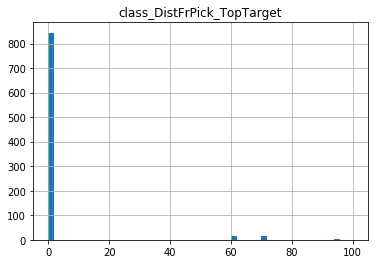

In [91]:
#df.hist(column='session_duration_seconds')
#test = df_all_wells_wKNN_DEPTHtoDEPT[[]]
test_df_1 = df_all_wells_wKNN_DEPTHtoDEPT.loc[df_all_wells_wKNN_DEPTHtoDEPT['UWI'] == '00/10-35-081-15W4/0']
test_df_1.hist(column='class_DistFrPick_TopTarget',bins=50)

------------------------------

## Use thickness from neighor and base to predict top just with that, add as feature
## NOTE: THIS IS COMMENTED OUT AS IT WAS DONE IN KNN NOTEBOOK NOW

In [ ]:
# l_df['new_pick']=l_df['Pick']-l_df['DEPT']

In [ ]:
# df_all_wells_wKNN['diff_Pick_v_DEPT'] = df_all_wells_wKNN['Pick'] - df_all_wells_wKNN['DEPT']

In [ ]:
#df_all_wells_wKNN_DEPTHtoDEPT['MM_Top_Depth_predBy_NN1thick'][0:1]

In [ ]:
#### Takes MM_Top_Depth_predBy_NN1thick and subtracts depth at that point, returns *absolute* value
# def NN1_TopMcMDepth_Abs(df,MM_Top_Depth_predBy_NN1thick):
#     df['DistFrom_NN1_TopDepth_Abs'] = abs(df[MM_Top_Depth_predBy_NN1thick] - df['DEPT'])
#     return df

In [ ]:
# df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM = NN1_TopMcMDepth_Abs(df_all_wells_wKNN_DEPTHtoDEPT,'MM_Top_Depth_predBy_NN1thick')

In [92]:
df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM = df_all_wells_wKNN_DEPTHtoDEPT

----------------

## Finally, we'll create a variety of calculated features based on well log numbers at, above, below, and around each depth point.

#### The difficult thing about creating features based on windows within a well when you have multiple wells stacked in a dataframe is that sometimes that window from one well goes into the next well.

#### To get around that, we're going create a column that says the distance from the top of the well and another column that says the distance form the bottom of the well. When a row's distance from top or bottom is greater than 1/2 the max window size, we'll just use proceed as normal. When the distance between that row's depth and top or bottom is less than 1/2 the max window size, we'll .....................

In [93]:
#
df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM['NewWell'] = df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM['UWI'].shift(1) != df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM['UWI']
df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM['LastBitWell'] = df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM['UWI'].shift(-1) != df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM['UWI']


In [94]:
df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM[0:1000]

,CALI,COND,DELT,DEPT,DPHI,DT,GR,ILD,ILM,NPHI,PHID,RHOB,SFL,SFLU,SN,SP,UWI,trainOrTest,SitID,lat,lng,TopHelper_HorID,TopTarget_HorID,TopHelper_DEPTH,TopTarget_DEPTH,TopHelper_HorID_Qual,TopTarget_Qual,Neighbors_Obj,NN1_topTarget_DEPTH,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,diff_Top_Depth_Real_v_predBy_NN1thick,diff_TopTarget_DEPTH_v_rowDEPT,diff_TopHelper_DEPTH_v_rowDEPT,class_DistFrPick_TopTarget,class_DistFrPick_TopHelper,NewWell,LastBitWell
0,167.003,NaN,NaN,149.602,0.227,NaN,102.473,0.000,NaN,0.460,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,train,112385,55.978836,-113.095365,14000,13000,384.66,377.95,1,3,"[{'neighbor': 1, 'UWI': '00/10-18-080-20W4/0', 'distance': 0.0507719894528512}, {'neighbor': 2, 'UWI': '00/10-18-081-20W4/0', 'distance': 0.05092214506480033}, {'neighbor': 3, 'UWI': '00/07-32-081-20W4/0', 'distance': 0.08365500059769317}, {'neighbor': 4, 'UWI': 'AA/11-14-081-20W4/0', 'distance': 0.08411400899372744}, {'neighbor': 5, 'UWI': '00/07-36-079-21W4/0', 'distance': 0.10481234193072116}, {'neighbor': 6, 'UWI': '00/13-10-081-21W4/0', 'distance': 0.12170796207727541}, {'neighbor': 7, 'UWI': '00/07-11-082-20W4/0', 'distance': 0.13725963708606176}]",389.00,414.0,25.00,359.66,18.29,228.348,235.058,0,0,True,False
1,199.159,NaN,NaN,149.852,0.263,NaN,122.589,4.202,NaN,0.550,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,train,112385,55.978836,-113.095365,14000,13000,384.66,377.95,1,3,"[{'neighbor': 1, 'UWI': '00/10-18-080-20W4/0', 'distance': 0.0507719894528512}, {'neighbor': 2, 'UWI': '00/10-18-081-20W4/0', 'distance': 0.05092214506480033}, {'neighbor': 3, 'UWI': '00/07-32-081-20W4/0', 'distance': 0.08365500059769317}, {'neighbor': 4, 'UWI': 'AA/11-14-081-20W4/0', 'distance': 0.08411400899372744}, {'neighbor': 5, 'UWI': '00/07-36-079-21W4/0', 'distance': 0.10481234193072116}, {'neighbor': 6, 'UWI': '00/13-10-081-21W4/0', 'distance': 0.12170796207727541}, {'neighbor': 7, 'UWI': '00/07-11-082-20W4/0', 'distance': 0.13725963708606176}]",389.00,414.0,25.00,359.66,18.29,228.098,234.808,0,0,False,False
2,200.496,NaN,NaN,150.102,0.252,NaN,120.196,4.643,NaN,0.537,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,train,112385,55.978836,-113.095365,14000,13000,384.66,377.95,1,3,"[{'neighbor': 1, 'UWI': '00/10-18-080-20W4/0', 'distance': 0.0507719894528512}, {'neighbor': 2, 'UWI': '00/10-18-081-20W4/0', 'distance': 0.05092214506480033}, {'neighbor': 3, 'UWI': '00/07-32-081-20W4/0', 'distance': 0.08365500059769317}, {'neighbor': 4, 'UWI': 'AA/11-14-081-20W4/0', 'distance': 0.08411400899372744}, {'neighbor': 5, 'UWI': '00/07-36-079-21W4/0', 'distance': 0.10481234193072116}, {'neighbor': 6, 'UWI': '00/13-10-081-21W4/0', 'distance': 0.12170796207727541}, {'neighbor': 7, 'UWI': '00/07-11-082-20W4/0', 'distance': 0.13725963708606176}]",389.00,414.0,25.00,359.66,18.29,227.848,234.558,0,0,False,False
3,203.933,NaN,NaN,150.352,0.244,NaN,115.975,5.280,NaN,0.513,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,train,112385,55.978836,-113.095365,14000,13000,384.66,377.95,1,3,"[{'neighbor': 1, 'UWI': '00/10-18-080-20W4/0', 'distance': 0.0507719894528512}, {'neighbor': 2, 'UWI': '00/10-18-081-20W4/0', 'distance': 0.05092214506480033}, {'neighbor': 3, 'UWI': '00/07-32-081-20W4/0', 'distance': 0.08365500059769317}, {'neighbor': 4, 'UWI': 'AA/11-14-081-20W4/0', 'distance': 0.08411400899372744}, {'neighbor': 5, 'UWI': '00/07-36-079-21W4/0', 'distance': 0.10481234193072116}, {'neighbor': 6, 'UWI': '00/13-10-081-21W4/0', 'distance': 0.12170796207727541}, {'neighbor': 7, 'UWI': '00/07-11-082-20W4/0', 'distance': 0.13725963708606176}]",389.00,414.0,25.00,359.66,18.29,227.598,234.308,0,0,False,False
4,203.664,NaN,NaN,150.602,0.240,NaN,109.271,6.592,NaN,0.487,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,train,112385,55.978836,-113.095365,14000,13000,384.66,377.95,1,3,"[{'neighbor': 1, 'UWI': '00/10-18-080-20W4/0', 'distance': 0.0507719894528512}, {'neighbor': 2, 'UWI': '00/10-18-081-20W4/0', 'distance': 0.05092214506480033}, {'neighbor': 3, '

In [95]:
# df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM['TopOfWell'] = np.where(df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM[NewWell] == True,,


# df['elderly'] = np.where(df['age']>=50, 'yes', 'no')

In [96]:
TopOfWellRowsOnly = df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM.loc[df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM['NewWell'] == True]
BottomOfWellRowsOnly = df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM.loc[df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM['LastBitWell'] == True]

In [97]:
#rename depth to top and bottom depths , delete all other columns
TopOfWellRowsOnly = TopOfWellRowsOnly[['UWI','DEPT']]
TopOfWellRowsOnly['TopWellDept'] = TopOfWellRowsOnly['DEPT']
TopOfWellRowsOnly.drop(['DEPT'],axis=1, inplace=True)
#### same thing for bottom
BottomOfWellRowsOnly = BottomOfWellRowsOnly[['UWI','DEPT']]
BottomOfWellRowsOnly['BotWellDept'] = BottomOfWellRowsOnly['DEPT']
BottomOfWellRowsOnly.drop(['DEPT'],axis=1, inplace=True)
#### merge these two small dataframes
TopAndBottomOfWellRowsOnly = pd.merge(TopOfWellRowsOnly, BottomOfWellRowsOnly, on='UWI')
#### merge with larger dataframe
df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM = pd.merge(df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM, TopAndBottomOfWellRowsOnly, on='UWI')

In [98]:
df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM.head()

,CALI,COND,DELT,DEPT,DPHI,DT,GR,ILD,ILM,NPHI,PHID,RHOB,SFL,SFLU,SN,SP,UWI,trainOrTest,SitID,lat,lng,TopHelper_HorID,TopTarget_HorID,TopHelper_DEPTH,TopTarget_DEPTH,TopHelper_HorID_Qual,TopTarget_Qual,Neighbors_Obj,NN1_topTarget_DEPTH,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,diff_Top_Depth_Real_v_predBy_NN1thick,diff_TopTarget_DEPTH_v_rowDEPT,diff_TopHelper_DEPTH_v_rowDEPT,class_DistFrPick_TopTarget,class_DistFrPick_TopHelper,NewWell,LastBitWell,TopWellDept,BotWellDept
0,167.003,NaN,NaN,149.602,0.227,NaN,102.473,0.000,NaN,0.460,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,train,112385,55.978836,-113.095365,14000,13000,384.66,377.95,1,3,"[{'neighbor': 1, 'UWI': '00/10-18-080-20W4/0', 'distance': 0.0507719894528512}, {'neighbor': 2, 'UWI': '00/10-18-081-20W4/0', 'distance': 0.05092214506480033}, {'neighbor': 3, 'UWI': '00/07-32-081-20W4/0', 'distance': 0.08365500059769317}, {'neighbor': 4, 'UWI': 'AA/11-14-081-20W4/0', 'distance': 0.08411400899372744}, {'neighbor': 5, 'UWI': '00/07-36-079-21W4/0', 'distance': 0.10481234193072116}, {'neighbor': 6, 'UWI': '00/13-10-081-21W4/0', 'distance': 0.12170796207727541}, {'neighbor': 7, 'UWI': '00/07-11-082-20W4/0', 'distance': 0.13725963708606176}]",389.0,414.0,25.0,359.66,18.29,228.348,235.058,0,0,True,False,149.602,396.102
1,199.159,NaN,NaN,149.852,0.263,NaN,122.589,4.202,NaN,0.550,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,train,112385,55.978836,-113.095365,14000,13000,384.66,377.95,1,3,"[{'neighbor': 1, 'UWI': '00/10-18-080-20W4/0', 'distance': 0.0507719894528512}, {'neighbor': 2, 'UWI': '00/10-18-081-20W4/0', 'distance': 0.05092214506480033}, {'neighbor': 3, 'UWI': '00/07-32-081-20W4/0', 'distance': 0.08365500059769317}, {'neighbor': 4, 'UWI': 'AA/11-14-081-20W4/0', 'distance': 0.08411400899372744}, {'neighbor': 5, 'UWI': '00/07-36-079-21W4/0', 'distance': 0.10481234193072116}, {'neighbor': 6, 'UWI': '00/13-10-081-21W4/0', 'distance': 0.12170796207727541}, {'neighbor': 7, 'UWI': '00/07-11-082-20W4/0', 'distance': 0.13725963708606176}]",389.0,414.0,25.0,359.66,18.29,228.098,234.808,0,0,False,False,149.602,396.102
2,200.496,NaN,NaN,150.102,0.252,NaN,120.196,4.643,NaN,0.537,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,train,112385,55.978836,-113.095365,14000,13000,384.66,377.95,1,3,"[{'neighbor': 1, 'UWI': '00/10-18-080-20W4/0', 'distance': 0.0507719894528512}, {'neighbor': 2, 'UWI': '00/10-18-081-20W4/0', 'distance': 0.05092214506480033}, {'neighbor': 3, 'UWI': '00/07-32-081-20W4/0', 'distance': 0.08365500059769317}, {'neighbor': 4, 'UWI': 'AA/11-14-081-20W4/0', 'distance': 0.08411400899372744}, {'neighbor': 5, 'UWI': '00/07-36-079-21W4/0', 'distance': 0.10481234193072116}, {'neighbor': 6, 'UWI': '00/13-10-081-21W4/0', 'distance': 0.12170796207727541}, {'neighbor': 7, 'UWI': '00/07-11-082-20W4/0', 'distance': 0.13725963708606176}]",389.0,414.0,25.0,359.66,18.29,227.848,234.558,0,0,False,False,149.602,396.102
3,203.933,NaN,NaN,150.352,0.244,NaN,115.975,5.280,NaN,0.513,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,train,112385,55.978836,-113.095365,14000,13000,384.66,377.95,1,3,"[{'neighbor': 1, 'UWI': '00/10-18-080-20W4/0', 'distance': 0.0507719894528512}, {'neighbor': 2, 'UWI': '00/10-18-081-20W4/0', 'distance': 0.05092214506480033}, {'neighbor': 3, 'UWI': '00/07-32-081-20W4/0', 'distance': 0.08365500059769317}, {'neighbor': 4, 'UWI': 'AA/11-14-081-20W4/0', 'distance': 0.08411400899372744}, {'neighbor': 5, 'UWI': '00/07-36-079-21W4/0', 'distance': 0.10481234193072116}, {'neighbor': 6, 'UWI': '00/13-10-081-21W4/0', 'distance': 0.12170796207727541}, {'neighbor': 7, 'UWI': '00/07-11-082-20W4/0', 'distance': 0.13725963708606176}]",389.0,414.0,25.0,359.66,18.29,227.598,234.308,0,0,False,False,149.602,396.102
4,203.664,NaN,NaN,150.602,0.240,NaN,109.271,6.592,NaN,0.487,NaN,NaN,NaN,NaN,NaN,NaN,00/10-32-080-20W4/0,train,112385,55.978836,-113.095365,14000,13000,384.66,377.95,1,3,"[{'neighbor': 1, 'UWI': '00/10-18-080-20W4/0', 'distance': 0.0507719894528512}, {'neighbor': 2, '

In [99]:
#### Create a col for distance from row to top of well
df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM['FromTopWell'] = df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM['DEPT'] - df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM['TopWellDept']

#### Create a col for distance from row to bottom of well
df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM['FromBotWell'] = df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM['BotWellDept'] - df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM['DEPT']

#### Create col for well total thickness measured
df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM['WellThickness'] = df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM['BotWellDept'] - df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM['TopWellDept']


#### This adds a column that says whether a row is closer to the bottm or the top of the well
#### This is useful for doing creation of features of rolling windows where you want to avoid going into another well stacked above.

In [100]:
#### This adds a column that says whether a row is closer to the bottm or the top of the well
#### This is useful for doing creation of features of rolling windows where you want to avoid going into another well stacked above.
df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM['closerToBotOrTop'] = np.where(df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM['FromTopWell']<=df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM['FromBotWell'], 'FromTopWell', 'FromBotWell')

In [101]:
df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM['closTopBotDist'] = np.where(df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM['FromTopWell']<=df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM['FromBotWell'], df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM['FromTopWell'], df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM['FromBotWell'])

In [102]:
df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM['rowsToEdge'] = df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM['closTopBotDist']/0.25
df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM['rowsToEdge'] = df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM['rowsToEdge'].astype(int)

----------------

## Writing dataframe to pickle file before doing main feature creation step that uses curves

In [105]:
#### dumping dict of data frame to pickle file
df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM_20180724 = df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM
pickle.dump(df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM_20180724, open( "df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM_20181003.p", "wb" ) )

## Reading in the same dataframe from pickle file

In [106]:
df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM_NearTop =  pd.read_pickle('df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM_20181003.p')

---------------------

## The following is a rewrite of the basic features calculated from the curves
### It runs faster than previous Pandas version could be made to run faster, specifically by using `apply` less
### It also calculates things in a window around a point, above a point, but not below a point. I have to go back and re-write that code. Sorting is expensive task in Dask, so I don't want to reverse order twice for each feature like I did previously in Pandas. 

-------------------

#### The next two lines bring up a Dask client dashboard that will open as a new tab. It provides great insight into what functions are being run by dask, how they run, and which ones are slowest.

In [107]:
client = Client()

In [108]:
client

Client Scheduler: tcp://127.0.0.1:51449 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 17.18 GB


The next bit is only creating features based on curve data within a given well, so we'll read and write pickle files at the start and end of this section.

In [109]:
%time
test_5 = df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM_NearTop.copy()
test_5 = dd.from_pandas(test_5, npartitions=50)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 13.8 µs


### In the line below, we pick the curves and windows to run

In [110]:
curves = ['GR','ILD','NPHI','DPHI']
windows = [5,7,11,21]

### The function nLargest is used via `apply`, I should probably re-write this to use Dask's Nlargest API but didn't here as the docs imply it might behave slightly differently.
### A quick look at the status dashboard in the Dask Client suggests the use of apply takes up maybe 1/4-1/2 of total compute time currently!

In [111]:
def nLargest(array,nValues):
    answer = np.mean(array[np.argsort(array)[-nValues:]])  
    return answer

In [112]:
def thoughts_seperateRollingAndConditionalIntoTwoDaskProcesses(dd,curves,windows):
    """
    for loop for each combination of parameter for rolling functions
    curves = ['GR','ILD']
    windows = [5,7,11,21]
    directions = ["around","below","above"]
        #         Not sure the best way to do the 'below' centered rolling in dask as the sort_index is expensive in dask so might be slow!
        #       Skipping this for now will come back when not tired. Maybe use shift?
    For each column created, check window size vs. allowable window size column, if too small, use single row value from original column
    """
    comboArg_B = [curves,windows]
    all_comboArgs_B = list(itertools.product(*comboArg_B))
    for eachArgList in all_comboArgs_B:
        col = eachArgList[0]
        windowSize = eachArgList[1]
        #centered = eachArgList[2]
        featureName = col+"_min_"+str(windowSize)+"winSize_"
        half_window = int(windowSize/2)
        #         quarter_window = int(windowSize/4)

        
        ### goes through distance to edge and when less than windowSize writes "too close" otherwise returns NaN
        ### fills in Nan with calculated feature column
        ### replaces "too close" with NaN
        ### replaces NaN with dd[col]
        ### overrights original column
        
        #### MIN
        dd[featureName+'dir'+'Around'+'Min'] = dd[col].rolling(windowSize,center=True).min()
        dd[featureName+'dir'+'Around'+'Min'] = dd[featureName+'dir'+'Around'+'Min'].where(cond=dd['closTopBotDist'] > half_window, other=dd[col])
        
        dd[featureName+'dir'+'Above'+'Min'] = dd[col].rolling(windowSize,center=False).min()
        dd[featureName+'dir'+'Above'+'Min'] = dd[featureName+'dir'+'Above'+'Min'].where(cond=dd['closTopBotDist'] > windowSize, other=dd[col])
        #### MAX
        dd[featureName+'dir'+'Around'+'Max'] = dd[col].rolling(windowSize,center=True).max()
        dd[featureName+'dir'+'Around'+'Max'] = dd[featureName+'dir'+'Around'+'Max'].where(cond=dd['closTopBotDist'] > half_window, other=dd[col])
        
        dd[featureName+'dir'+'Above'+'Max'] = dd[col].rolling(windowSize,center=False).max()
        dd[featureName+'dir'+'Above'+'Max'] = dd[featureName+'dir'+'Above'+'Max'].where(cond=dd['closTopBotDist'] > windowSize, other=dd[col])
        #### Mean
        dd[featureName+'dir'+'Around'+'Mean'] = dd[col].rolling(windowSize,center=True).mean()
        dd[featureName+'dir'+'Around'+'Mean'] = dd[featureName+'dir'+'Around'+'Mean'].where(cond=dd['closTopBotDist'] > half_window, other=dd[col])
        
        dd[featureName+'dir'+'Above'+'Mean'] = dd[col].rolling(windowSize,center=False).mean()
        dd[featureName+'dir'+'Above'+'Mean'] = dd[featureName+'dir'+'Above'+'Mean'].where(cond=dd['closTopBotDist'] > windowSize, other=dd[col])

        ## nLargest
        nValues = 5
        dd[featureName+'dir'+'Above'+'nLarge'] = dd[col].rolling(windowSize,center=False).apply( lambda x: nLargest(x,nValues),raw=True)  
        dd[featureName+'dir'+'Above'+'nLarge'] = dd[featureName+'dir'+'Above'+'nLarge'].where(cond=dd['closTopBotDist'] > windowSize, other=dd[col])
        
        dd[featureName+'dir'+'Around'+'nLarge'] = dd[col].rolling(windowSize,center=True).apply(lambda x: nLargest(x,nValues),raw=True) 
        dd[featureName+'dir'+'Around'+'nLarge'] = dd[featureName+'dir'+'Around'+'nLarge'].where(cond=dd['closTopBotDist'] > windowSize, other=dd[col])
    
    return dd

In [113]:
%time
ddf_test5 = thoughts_seperateRollingAndConditionalIntoTwoDaskProcesses(test_5,curves,windows)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 9.06 µs


In [114]:
%time
test5result = ddf_test5.compute()


CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 9.78 µs


In [118]:
%time
test5result.head()

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 9.06 µs


,CALI,COND,DELT,DEPT,DPHI,DT,GR,ILD,ILM,NPHI,PHID,RHOB,SFL,SFLU,SN,SP,UWI,trainOrTest,SitID,lat,lng,TopHelper_HorID,TopTarget_HorID,TopHelper_DEPTH,TopTarget_DEPTH,TopHelper_HorID_Qual,TopTarget_Qual,Neighbors_Obj,NN1_topTarget_DEPTH,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,diff_Top_Depth_Real_v_predBy_NN1thick,diff_TopTarget_DEPTH_v_rowDEPT,diff_TopHelper_DEPTH_v_rowDEPT,class_DistFrPick_TopTarget,class_DistFrPick_TopHelper,NewWell,LastBitWell,TopWellDept,BotWellDept,FromTopWell,FromBotWell,WellThickness,closerToBotOrTop,closTopBotDist,rowsToEdge,GR_min_5winSize_dirAroundMin,GR_min_5winSize_dirAboveMin,GR_min_5winSize_dirAroundMax,GR_min_5winSize_dirAboveMax,GR_min_5winSize_dirAroundMean,GR_min_5winSize_dirAboveMean,GR_min_5winSize_dirAbovenLarge,GR_min_5winSize_dirAroundnLarge,GR_min_7winSize_dirAroundMin,GR_min_7winSize_dirAboveMin,GR_min_7winSize_dirAroundMax,GR_min_7winSize_dirAboveMax,GR_min_7winSize_dirAroundMean,GR_min_7winSize_dirAboveMean,GR_min_7winSize_dirAbovenLarge,GR_min_7winSize_dirAroundnLarge,GR_min_11winSize_dirAroundMin,GR_min_11winSize_dirAboveMin,GR_min_11winSize_dirAroundMax,GR_min_11winSize_dirAboveMax,GR_min_11winSize_dirAroundMean,GR_min_11winSize_dirAboveMean,GR_min_11winSize_dirAbovenLarge,GR_min_11winSize_dirAroundnLarge,GR_min_21winSize_dirAroundMin,GR_min_21winSize_dirAboveMin,GR_min_21winSize_dirAroundMax,GR_min_21winSize_dirAboveMax,GR_min_21winSize_dirAroundMean,GR_min_21winSize_dirAboveMean,GR_min_21winSize_dirAbovenLarge,GR_min_21winSize_dirAroundnLarge,ILD_min_5winSize_dirAroundMin,ILD_min_5winSize_dirAboveMin,ILD_min_5winSize_dirAroundMax,ILD_min_5winSize_dirAboveMax,ILD_min_5winSize_dirAroundMean,ILD_min_5winSize_dirAboveMean,ILD_min_5winSize_dirAbovenLarge,ILD_min_5winSize_dirAroundnLarge,ILD_min_7winSize_dirAroundMin,ILD_min_7winSize_dirAboveMin,ILD_min_7winSize_dirAroundMax,ILD_min_7winSize_dirAboveMax,ILD_min_7winSize_dirAroundMean,ILD_min_7winSize_dirAboveMean,ILD_min_7winSize_dirAbovenLarge,ILD_min_7winSize_dirAroundnLarge,ILD_min_11winSize_dirAroundMin,ILD_min_11winSize_dirAboveMin,ILD_min_11winSize_dirAroundMax,ILD_min_11winSize_dirAboveMax,ILD_min_11winSize_dirAroundMean,ILD_min_11winSize_dirAboveMean,ILD_min_11winSize_dirAbovenLarge,ILD_min_11winSize_dirAroundnLarge,ILD_min_21winSize_dirAroundMin,ILD_min_21winSize_dirAboveMin,ILD_min_21winSize_dirAroundMax,ILD_min_21winSize_dirAboveMax,ILD_min_21winSize_dirAroundMean,ILD_min_21winSize_dirAboveMean,ILD_min_21winSize_dirAbovenLarge,ILD_min_21winSize_dirAroundnLarge,NPHI_min_5winSize_dirAroundMin,NPHI_min_5winSize_dirAboveMin,NPHI_min_5winSize_dirAroundMax,NPHI_min_5winSize_dirAboveMax,NPHI_min_5winSize_dirAroundMean,NPHI_min_5winSize_dirAboveMean,NPHI_min_5winSize_dirAbovenLarge,NPHI_min_5winSize_dirAroundnLarge,NPHI_min_7winSize_dirAroundMin,NPHI_min_7winSize_dirAboveMin,NPHI_min_7winSize_dirAroundMax,NPHI_min_7winSize_dirAboveMax,NPHI_min_7winSize_dirAroundMean,NPHI_min_7winSize_dirAboveMean,NPHI_min_7winSize_dirAbovenLarge,NPHI_min_7winSize_dirAroundnLarge,NPHI_min_11winSize_dirAroundMin,NPHI_min_11winSize_dirAboveMin,NPHI_min_11winSize_dirAroundMax,NPHI_min_11winSize_dirAboveMax,NPHI_min_11winSize_dirAroundMean,NPHI_min_11winSize_dirAboveMean,NPHI_min_11winSize_dirAbovenLarge,NPHI_min_11winSize_dirAroundnLarge,NPHI_min_21winSize_dirAroundMin,NPHI_min_21winSize_dirAboveMin,NPHI_min_21winSize_dirAroundMax,NPHI_min_21winSize_dirAboveMax,NPHI_min_21winSize_dirAroundMean,NPHI_min_21winSize_dirAboveMean,NPHI_min_21winSize_dirAbovenLarge,NPHI_min_21winSize_dirAroundnLarge,DPHI_min_5winSize_dirAroundMin,DPHI_min_5winSize_dirAboveMin,DPHI_min_5winSize_dirAroundMax,DPHI_min_5winSize_dirAboveMax,DPHI_min_5winSize_dirAroundMean,DPHI_min_5winSize_dirAboveMean,DPHI_min_5winSize_dirAbovenLarge,DPHI_min_5winSize_dirAroundnLarge,DPHI_min_7winSize_dirAroundMin,DPHI_min_7winSize_dirAboveMin,DPHI_min_7winSize_dirAroundMax,DPHI_min_7winSize_dirAboveMax,DPHI_min_7winSize_dirAroundMean,DPHI_min_7winSize_dirAboveMean,DPHI_min

In [116]:
type(test5result)

pandas.core.frame.DataFrame

In [117]:
len(test5result.columns)

175

--------------------

## Writing pandas dataframe to pickle

In [119]:
#### dumping dict of data frame to pickle file
df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM__NearTop_CurveF_20181003 = test5result
pickle.dump(df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM__NearTop_CurveF_20181003, open( "df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM_20181003.p", "wb" ) )

In [120]:
df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM_NearTop_2 =  pd.read_pickle("df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM_20181003.p")

## Write pandas dataframe to hdf5 
#### Dropping [Neighbors_Obj] col as it is object and can't be written to HDF5

In [121]:
#### Change name and drop [Neighbors_Obj]
df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM_NearTop_3 = df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM_NearTop_2.drop(['Neighbors_Obj'], axis=1)


In [122]:
# Write hdf5 to current directory
df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM_NearTop_3.to_hdf('df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM_20181003.h5', key='df', mode='w')

-----------------------

## Explore adding features based on map position using widget to draw polygons which are then one-hot encoded?

## Any other features?

In [16]:
!ls

createFeat_20180707_vA-Copy1.ipynb
createFeat_20180707_vA.ipynb
createFeat_20180707_vB.ipynb
createFeat_20180707_vC.ipynb
createFeat_20180725_vD.ipynb
dask-worker-space
df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM_20180724
df_all_wells_wKNN_DEPTHtoDEPT_KNN1PredTopMcM_20180724.p
dict_of__wells_df_No_features_class3_20180707.p
